### Imports

In [21]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import math
import numpy as np
import torch.nn.functional as fn

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)


<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [18]:
batch_size = 1                 # 64 used for Graphs in PGE (PGExplainer/codes/forgraph/config.py)      1 takes forever in current model
sampled_graphs = 20

learning_rate_mlp = 0.003        #0.003 on ADAM
coefficientSizeReg = 0.05
entropyReg = 1
epochs_mlp = 30

# Temperature
t_0 =  5.0
t_T = 2.0

datasetName: Literal['BA2Motif','MUTAG'] = 'BA2Motif'

### Load and visualize data

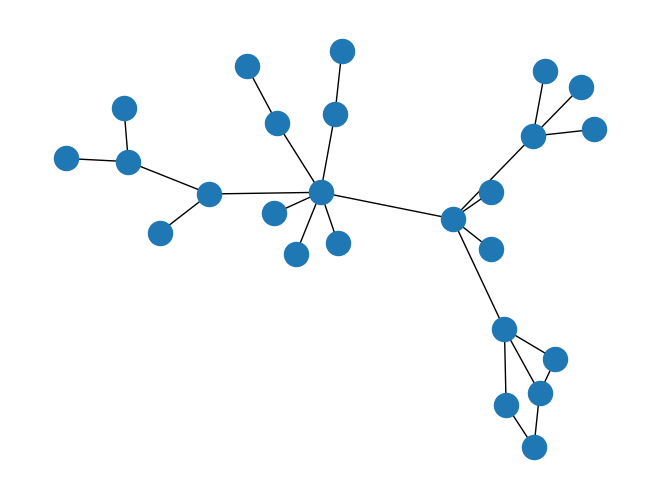

In [3]:
train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

# TODO: Color different classes? Problem: BA2Motif Graph datasets have no node labels?!
g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g)

train_loader = DataLoader(train_dataset, batch_size, False)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! To improve: Add hidden embeddings to data objects????
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

### Load GNN model

In [4]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/BA2Motif 100", weights_only=True))

<All keys matched successfully>

In [19]:
def weights_init(module):
    # TODO: GraphConv has no attribute weight!!
    #if isinstance(module, gnn.GraphConv):
    #    nn.init.xavier_normal_(module.weight.data)
    #    if module.bias is not None:
     
    # This only initializes weight for lin layer, not GraphConv
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        #if module.bias is not None:            # Xavier not usable for bias?


### Training Loop Graph Classification Explainer

In [22]:
mlp = networks.MLP(features= 40)

mlp.apply(weights_init)             # TODO: Validate

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp)

embeddings = []
preds = []

f = nn.Sigmoid()

# 1. For each Graph calculate the embeddings and predictions on a trained model
for batch_index, data in enumerate(train_loader):

    emb = modelGraphGNN.getNodeEmbeddings(data.x, data.edge_index)              # shape: 25 X 20 = Nodes X hidden_embs

    #embeddings.append(embCat)         # embeddings: 25 X 20 = Nodes X hidden_embs
    # TODO: Transform embeddings so that they contain the concatenated hidden_embs of each two connected nodes

    graph_embs = []
    for index in range(0, len(data.edge_index[0])):
        i = data.edge_index[0][index]
        j = data.edge_index[1][index]

        embCat = torch.cat([emb[i],emb[j]])                     # shape: 1 X 40 = 1Edge X hidden_embs_2Nodes

        graph_embs.append(embCat)                               # shape: ~50 X 40 = Edges X hidden_embs_2Nodes

    # TODO: Embeddings still in list; okay??
    embeddings.append(torch.stack(graph_embs))                  # shape: 600 X ~50 X 40 = Graphs X Edges X hidden_embs_2Nodes           
    #embeddings.append(graph_embs)
    
    preds.append(modelGraphGNN.forward(data.x, data.edge_index, data.batch))        # shape: 600 X 2 = Graphs X Labels

# TODO: This "groups" batches into one dim?! Necessary / makes sense???
# embeddings_tensor = torch.cat(embeddings, dim=0)

for epoch in range(0, epochs_mlp) :

    mlp.train()

    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    Loss = 0.0

    for batch_index, data in enumerate(train_loader):

        # MLP forward                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        out = mlp.forward(embeddings[batch_index])              # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        preds_sample = []

        Y_true_one_hot = torch.nn.functional.one_hot(data.y, 2).float()  # shape: 2, = (num_classes,)        TODO: replace 2 labels by labels of selected dataset

        for k in range(0, sampled_graphs):
            # Sample with reparam trick

            w_ij = out.squeeze(1)                               # shape: ~50 X 1 = EdgesOG X MLP_out(edge_weight)

            #epsilon = np.random.uniform(0,1)
            epsilon = torch.rand(data.edge_index.size(1))       # shape: ~50 X 1 = EdgesOG X epsilon
            
            #edge_ij = f(torch.tensor((math.log(epsilon)-math.log(1-epsilon)+w_ij)/temperature))
            edge_ij = f((torch.log(epsilon)-torch.log(1-epsilon)+w_ij)/temperature)                     # shape: ~50 X 1 = EdgesOG X SampledEdgesProbability

            k_mask = edge_ij > 0.5                              # shape: ~50 X 1 = EdgesOG X SampledEdgesMask

            edge_index_masked = data.edge_index[:,k_mask]

            #print("---------------------------")
            #print(data.edge_index)
            #print(edge_index_masked)
            #print("---------------------------")

            # sampled edges create sampled graph
            Gs = Data(x=data.x, edge_index=edge_index_masked)   # 1 sampled graph

            # prediction of GNN on sampled graph
            ####preds_sample.append(modelGraphGNN.forward(Gs.x, Gs.edge_index))     # 1 prediction of sampled graph     => shape preds_sample: 20 X 2 = K X Labels

            Loss += mlp.loss(fn.softmax(preds[batch_index], dim=1), fn.softmax(modelGraphGNN.forward(Gs.x, Gs.edge_index),dim=1))
        
        #### all_preds_k = torch.cat(preds_sample, dim=0)                            # reshaped preds_sample: 20 X 2 = K X Labels
        #print(all_preds_k)

        #### mean_preds_k = torch.mean(torch.nn.functional.softmax(all_preds_k, dim=1), dim=0)                                                   # shape: 1 X 2 = meanGraphs X Labels
        #### Loss += torch.sum(torch.nn.functional.softmax(preds[batch_index], dim=1) * Y_true_one_hot * torch.log(mean_preds_k + 1e-8))         # TODO: Validate        2 X 2 X 2
        # TODO: Save all_preds_k for each graph into tensor or accumulate and mean?!
        
    
    #loss = mlp.loss()
    #### Loss = -Loss / len(train_loader)            # TODO: Validate, apply batchsizeratio
    Loss = -Loss / len(train_loader) / sampled_graphs

    print(Loss.item())

    Loss.backward(retain_graph=True)                     # TODO: Understand retain graph?!

    for name, param in mlp.named_parameters():
        if param.grad is not None:
            print(f"Parameter: {name}, Gradient Norm: {param.grad.norm().item()}")
        else:
            print(f"Parameter: {name} has no gradient!")

    mlp_optimizer.step()
    # Compute loss between preds and preds_sample


3.1306943893432617
Parameter: hidden1.weight has no gradient!
Parameter: hidden1.bias has no gradient!
Parameter: lin1.weight has no gradient!
Parameter: lin1.bias has no gradient!
3.139831781387329
Parameter: hidden1.weight has no gradient!
Parameter: hidden1.bias has no gradient!
Parameter: lin1.weight has no gradient!
Parameter: lin1.bias has no gradient!
3.142817258834839
Parameter: hidden1.weight has no gradient!
Parameter: hidden1.bias has no gradient!
Parameter: lin1.weight has no gradient!
Parameter: lin1.bias has no gradient!
3.1358137130737305
Parameter: hidden1.weight has no gradient!
Parameter: hidden1.bias has no gradient!
Parameter: lin1.weight has no gradient!
Parameter: lin1.bias has no gradient!
3.150320291519165
Parameter: hidden1.weight has no gradient!
Parameter: hidden1.bias has no gradient!
Parameter: lin1.weight has no gradient!
Parameter: lin1.bias has no gradient!


KeyboardInterrupt: 

tensor([1])
-----------------Original Graph-----------------
tensor([1])
-----------------Sampled Graph-----------------


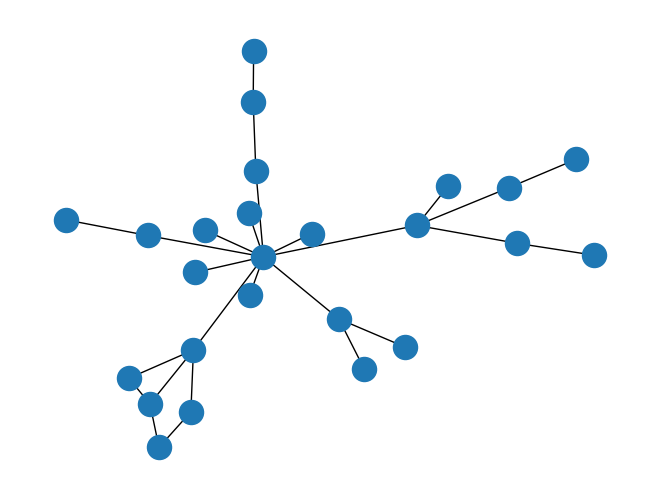

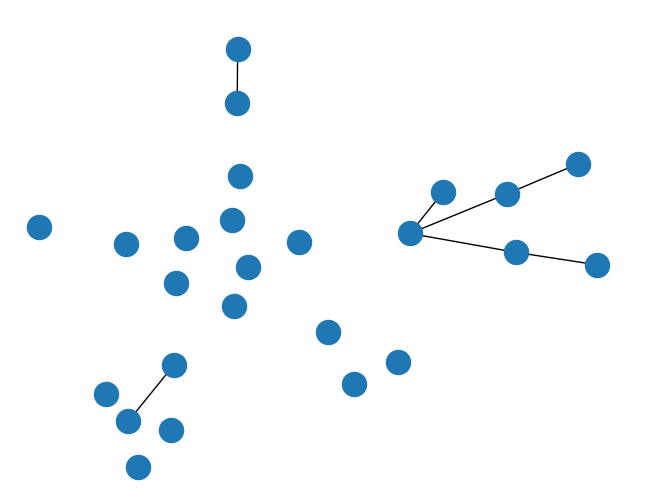

In [16]:
data1 = train_dataset[347]

print(data1.y)

temperature = t_0*((t_T/t_0) ** (1))

out = mlp.forward(embeddings[347])

w_ij = out.squeeze(1)
epsilon = torch.rand(data1.edge_index.size(1))


edge_ij = f((torch.log(epsilon)-torch.log(1-epsilon)+w_ij)/temperature)
k_mask = edge_ij > 0.5
edge_index_masked = data1.edge_index[:,k_mask]

Gs = Data(x=data.x, edge_index=edge_index_masked)

print("-----------------Original Graph-----------------")
gO = torch_geometric.utils.to_networkx(data1, to_undirected=True)
pos = nx.spring_layout(gO)
plt.figure(2)
nx.draw(gO, pos=pos)
print(data1.y)

print("-----------------Sampled Graph-----------------")
gS = torch_geometric.utils.to_networkx(Gs, to_undirected=True)
plt.figure(1)
nx.draw(gS, pos=pos)
#print(modelGraphGNN.forward(Gs.x, Gs.edge_index))

plt.show()

In [116]:
embeddings = []

for batch_index, data in enumerate(train_loader):
    emb = modelGraphGNN.getNodeEmbeddings(data.x, data.edge_index)

    print(data.edge_index)

    graph_embs = []
    for index in range(0, len(data.edge_index[0])):
        i = data.edge_index[0][index]
        j = data.edge_index[1][index]

        embCat = torch.cat([emb[i],emb[j]])

        graph_embs.append(embCat)

    embeddings.append(torch.stack(graph_embs))
    #embeddings.append(graph_embs)

embeddings_tensor = torch.cat(embeddings, dim=0)

print(embeddings_tensor[0])

tensor([[-5.2508, 11.0630]], grad_fn=<AddmmBackward0>)
tensor([[ 9.6208, -4.0149]], grad_fn=<AddmmBackward0>)
tensor([[-4.0721,  9.4047]], grad_fn=<AddmmBackward0>)
tensor([[ 9.9110, -6.9349]], grad_fn=<AddmmBackward0>)
tensor([[-3.2837,  9.7529]], grad_fn=<AddmmBackward0>)
tensor([[10.6987, -5.2598]], grad_fn=<AddmmBackward0>)
tensor([[-3.5091,  9.7168]], grad_fn=<AddmmBackward0>)
tensor([[-3.7315, 12.9849]], grad_fn=<AddmmBackward0>)
tensor([[11.5828, -4.2335]], grad_fn=<AddmmBackward0>)
tensor([[-3.4409, 10.3562]], grad_fn=<AddmmBackward0>)
tensor([[ 9.8674, -4.6952]], grad_fn=<AddmmBackward0>)
tensor([[10.3668, -6.0195]], grad_fn=<AddmmBackward0>)
tensor([[-3.1747,  9.4845]], grad_fn=<AddmmBackward0>)
tensor([[-2.6635,  8.9744]], grad_fn=<AddmmBackward0>)
tensor([[-4.6783,  9.5552]], grad_fn=<AddmmBackward0>)
tensor([[ 9.5728, -2.5476]], grad_fn=<AddmmBackward0>)
tensor([[-2.7421,  8.4150]], grad_fn=<AddmmBackward0>)
tensor([[ 9.3726, -6.0654]], grad_fn=<AddmmBackward0>)
tensor([[-

KeyboardInterrupt: 

In [108]:
epoch = 29

temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

w_ij = 0

epsilon = torch.rand(50)

f = nn.Sigmoid()
edge_ij = f((torch.log(epsilon)-torch.log(1-epsilon)+w_ij)/temperature)

print(edge_ij)

tensor([0.5403, 0.5449, 0.1911, 0.4021, 0.6988, 0.8581, 0.5198, 0.6216, 0.4258,
        0.5069, 0.7512, 0.3363, 0.3737, 0.4472, 0.6411, 0.7144, 0.6571, 0.6751,
        0.1854, 0.7845, 0.6040, 0.5683, 0.4978, 0.4599, 0.6382, 0.6363, 0.3146,
        0.2055, 0.6586, 0.5390, 0.6305, 0.6316, 0.5751, 0.7709, 0.6161, 0.6927,
        0.3890, 0.4298, 0.5041, 0.5640, 0.7247, 0.5353, 0.2897, 0.6789, 0.3778,
        0.6280, 0.4984, 0.9004, 0.4593, 0.2773])


In [96]:
import torch
from torch_geometric.data import Data

# Example: Create a graph with 4 nodes and 5 edges
edge_index = torch.tensor([[0, 1, 2, 3, 4],
                           [1, 2, 3, 4, 0]], dtype=torch.long)
x = torch.randn((5, 3))  # Node features

# Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Number of edges in the graph
num_edges = data.edge_index.size(1)

# Generate a random binary mask for edges (e.g., 50% chance of being included)
edge_mask = torch.rand(num_edges) < 0.5  # 50% chance of being True

# Apply the edge mask: only keep the edges where the mask is True
masked_edge_index = data.edge_index[:, edge_mask]

# Print the results
print("Original Edge Index:\n", data.edge_index)
print("Edge Mask:\n", edge_mask)
print("Masked Edge Index:\n", masked_edge_index)


Original Edge Index:
 tensor([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0]])
Edge Mask:
 tensor([False,  True,  True, False,  True])
Masked Edge Index:
 tensor([[1, 2, 4],
        [2, 3, 0]])
